### <center> Examples of Image Decoding and Recovery using Shearlet transform </center>

We will compute the Digital Shearlet Transform of a signal $f$ by the equation
$$\text{DST}_{j,k,m}^{2D}(f) = \left(\overline{\psi^d_{j,k}}*f_J\right)\left(2^J A_{2^j}^{-1}M_{c_j}m\right) \text{ for } j=0,1,...,J-1 $$

where $\psi^d_{j,k} = S^d_{k/2^{j/2}}(p_j*W_j)$ ( with $S^d_{k/2^{j/2}}$ the digital shearing operator already implemented, $p_j(n)$ are the Fourier coefficients of the fan filter P (associated to the shearlet generator function) and $W_j=g_{J-j}\otimes h_{J-j}$ ($h_j$ low-pass filter associated to the scaling function and $g_j$ high pass filter, mirror filter of h, associated to the wavelet function), and $A_{2^j}$ is the parabolic scaling matrix given by
$$ A_{2^j} = \left( \begin{matrix} 2^j & 0 \\ 0 & 2^{j/2} \end{matrix}\right) $$
and the Shearing transform is given by
$$ S_k = \left( \begin{matrix} 1 & k \\ 0 & 1 \end{matrix}\right)$$

Lets define the scaling and wavelet filters now in each scale by:
$$ 
\hat{h}_j(\xi_1)=\prod_{k=0}^{j-1}\hat{h}(2^k\xi_1) 
\text{    ,    }  
\hat{g}_j(\xi_1)=\hat{g}\left(\frac{2^j\xi_1}{2}\right) \hat{h}_{j-1}(\xi_1)
$$
and the directional filter transform 
$p_j(\xi_1,\xi_2)=\widehat{P(2^{J-j-1}\xi_1,2^{J-j/2}\xi_2)}$
for that one need to apply padding to the directional filter, looking carefully to $p_j*W_j=p_j*g_{J-j}\otimes h_{J-j}$ that is the vertical wavelet transform of the filter $p_j$.

#### Non separable transform and Digital Shearing.

In this case it was used a nonseparable shearlet generator
$$
\hat{\psi}(\xi)=P(\xi_1/2,\xi_2/2)\widehat{\psi_1\otimes \phi_1}(\xi)
$$
Because of $\psi_{j,k,m}(\cdot) = \psi_{j,0,m}(S_{k/2^{j/2}\cdot}$ and $\psi_{j,0}^{2D}=p_j*(g_{J-j}\otimes h_{J-j/2})$,the digital shearing to mantain the domain grid will be
$$
S_{k/2^{j/2}}(x)=\left(\left( x_{\uparrow 2^{j/2}}*_1h_{j/2}\right)(S_k\cdot)*_1\overline{h_{j/2}}\right)_{\downarrow 2^{j/2}}
$$
therefore 
$$
\psi_{j,k}^{2D} = S^d_{k/2^{j/2}}\psi_{j,0}^{2D}
$$
for $j\in\{0,J-1\}$ and $|k|\leq \lceil 2^{j/2}\rceil$.

In [1]:
# Clone the libraris
#Pkg.clone("https://github.com/arsenal9971/Shearlab.jl.git")

In [2]:
# Loard the Pkg
push!(LOAD_PATH,pwd()*"/../../src") 
import Shearlab
#using Shearlab
using PyPlot
reload("Shearlab")
using Images

In [5]:
# Read Data
n = 512;
# The path of the image
name = "../../data_samples/kodim12.jpg";
data_nopar = Shearlab.load_image(name, n);
data_par = Shearlab.load_image(name, n,n,1);

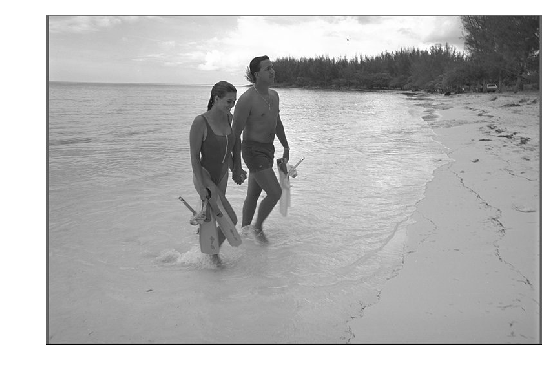

In [6]:
# Reduce one dimension 
data_nopar = data_nopar[:,:,1];
data_par = data_par[:,:,1]
Shearlab.imageplot(data_nopar);

In [8]:
sizeX_nopar = size(data_nopar,1);
sizeY_nopar = size(data_nopar,2);
sizeX_par = size(data_par,1);
sizeY_par = size(data_par,2);

In [9]:
# Set the variables for the Shearlet trasform
rows_nopar = sizeX_nopar;
cols_nopar = sizeY_nopar;
rows_par = sizeX_par;
cols_par = sizeY_par;
X_nopar = data_nopar; 
X_par = data_par; 
nScales = 4;
shearLevels = ceil.((1:nScales)/2)
scalingFilter = Shearlab.filt_gen("scaling_shearlet");
directionalFilter = Shearlab.filt_gen("directional_shearlet");
waveletFilter = Shearlab.mirror(scalingFilter);
scalingFilter2 = scalingFilter;
full = 0;

In [10]:
# Compute the corresponding shearlet system without gpu
@time shearletSystem_nopar= Shearlab.getshearletsystem2D(rows_nopar,cols_nopar,4, shearLevels,full,
                                directionalFilter,
                                scalingFilter,0);

 33.363517 seconds (6.84 M allocations: 12.524 GiB, 37.05% gc time)


In [9]:
#using ArrayFire

In [12]:
# Compute the corresponding shearlet system without gpu
#@time shearletSystem_par = Shearlab.getshearletsystem2D(rows_par,cols_par,nScales,shearLevels,full,
#                                directionalFilter,
#                                scalingFilter,1);

**Lets look at the shearlets at different scales.**

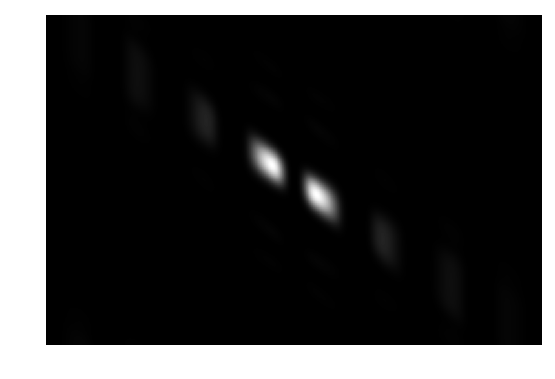

In [13]:
shearlet1 = Array(shearletSystem_nopar.shearlets[:,:,1]);
Shearlab.imageplot(real(shearlet1));

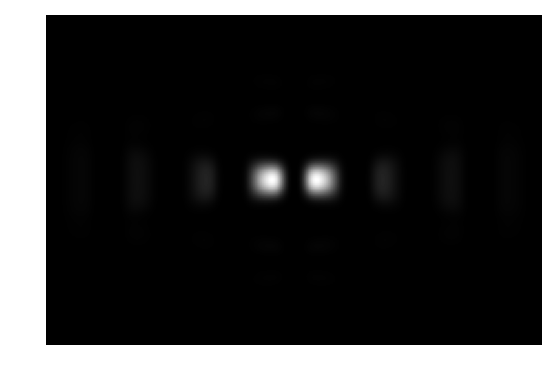

In [14]:
shearlet3 = Array(shearletSystem_nopar.shearlets[:,:,3]);
Shearlab.imageplot(real(shearlet3))

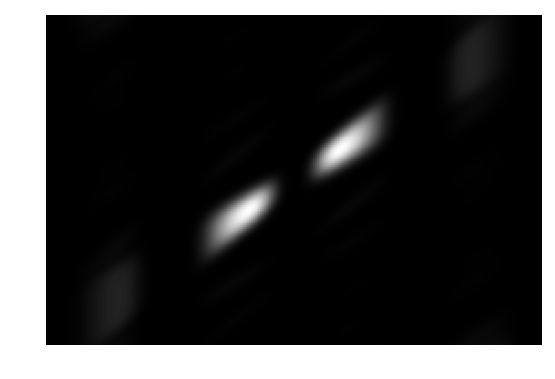

In [15]:
shearlet10 = Array(shearletSystem_nopar.shearlets[:,:,10]);
Shearlab.imageplot(real(shearlet10))

In [16]:
size(shearletSystem_nopar.shearlets)

(512, 768, 49)

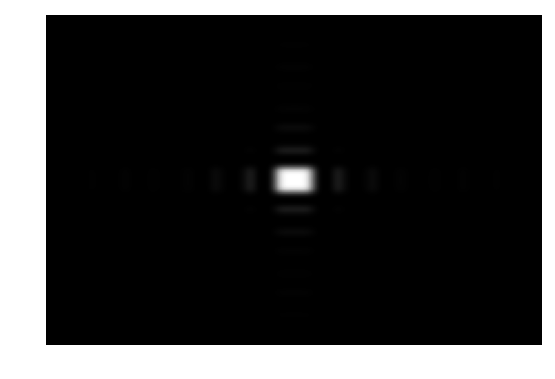

In [17]:
shearlet17 = Array(shearletSystem_nopar.shearlets[:,:,49]);
Shearlab.imageplot(real(shearlet17))

**Lets compute the shearlet coefficients for the data**

In [18]:
# Compute the coefficients
@time coeffs_nopar = Shearlab.SLsheardec2D(X_nopar,shearletSystem_nopar);

  2.122939 seconds (60.07 k allocations: 2.033 GiB, 28.44% gc time)


In [19]:
# Compute the coefficients in parallel
#X_par = AFArray(convert(Array{Float32},X_par));
#@time coeffs_par = Shearlab.SLsheardec2D(X_par,shearletSystem_par);

**Lets look at the shearlets coefficients at different scales.**

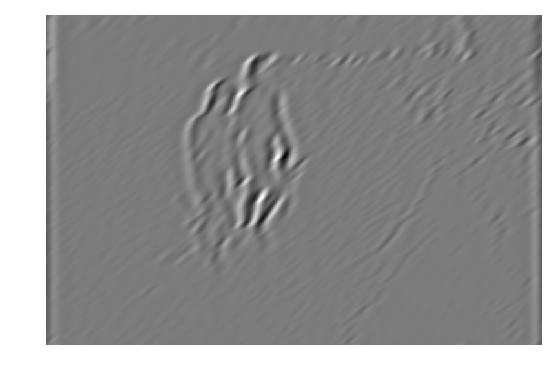

In [20]:
Shearlab.imageplot(real(Array(coeffs_nopar[:,:,1])))

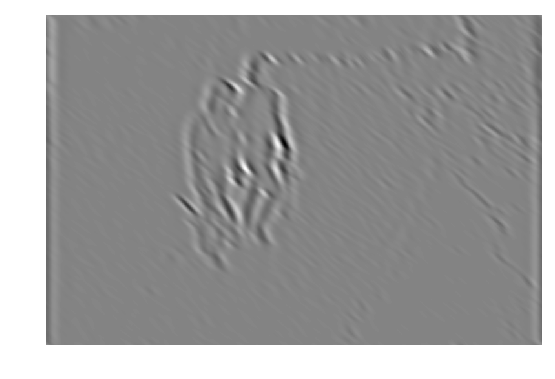

In [21]:
Shearlab.imageplot(real(Array(coeffs_nopar[:,:,5])))

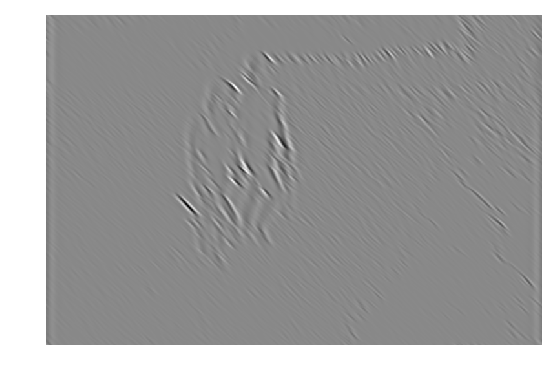

In [22]:
Shearlab.imageplot(real(Array(coeffs_nopar[:,:,10])))

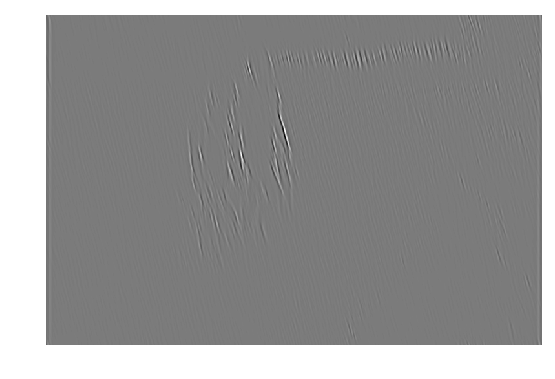

In [23]:
Shearlab.imageplot(real(Array(coeffs_nopar[:,:,16])))

**Lets compute the shearlet reconstruction of the data**

In [24]:
# Make the recovery
@time Xrec_nopar=Shearlab.SLshearrec2D(coeffs_nopar,shearletSystem_nopar);

  2.617282 seconds (129.03 k allocations: 2.048 GiB, 42.24% gc time)


In [25]:
# Make the recovery in parallel
#@time Xrec_par=Shearlab.SLshearrec2D(coeffs_par,shearletSystem_par);

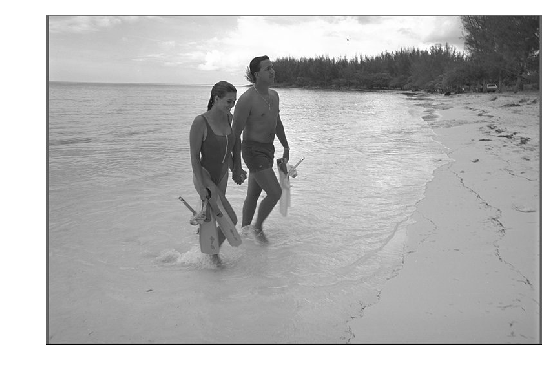

In [26]:
# The recovery is very good
Shearlab.imageplot(Array(Xrec_nopar));

In [27]:
# The recovery is very good
#Shearlab.imageplot(Array(Xrec_par));